### Loading Data

In [1]:
import pandas as pd

,Gmt time,open,high,low,close,volume
28855,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63
28856,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66
28857,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33
28858,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53
28859,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05


In [ ]:
# DATA SOURCE
df = pd.read_csv("/Users/sohail21400/Desktop/trading_machine/data/EURUSD/EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")
TPSLRatio = 2
pipdiff = 0.0001 # for TP

In [ ]:
df.tail()

In [2]:
#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
df.isna().sum()

Gmt time    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

## Adding Technical Indicators

In [4]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1, high=df['high'], low=df['low'], talib=False) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [5]:
df.tail()

,Gmt time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
28855,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001947,59.946065,1.160290,1.156618,1.159121,1.167880,0.000054,-0.000132,-0.000149,-0.000162,-1.237279
28856,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001947,58.038673,1.160920,1.156768,1.159014,1.167745,0.000090,-0.000125,-0.000145,0.000035,-0.095942
28857,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.001965,53.777344,1.160080,1.156853,1.158880,1.167604,0.000115,-0.000123,-0.000140,0.000233,0.033494
28858,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.001972,54.744468,1.159980,1.156944,1.158774,1.167468,0.000122,-0.000118,-0.000137,0.000164,-0.619952
28859,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001937,57.520290,1.159965,1.157065,1.158678,1.167336,0.000117,-0.000113,-0.000136,0.000028,-0.346306


In [63]:
# TODO: Understand this function

# Target flexible way
pipdiff = 500*1e-5  # for TP
TPSLRatio = 2  # pipdiff/Ratio gives SL


def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    atr = list(df1['ATR'])

    trendcat = [None] * length

    for line in range(0, length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        tp = atr[line] * 1.5
        for i in range(1, barsupfront+2):
            if atr[line] is not None:
                value1 = open[line+1]-low[line+i]
                value2 = open[line+1]-high[line+i]
                valueOpenLow = max(value1, valueOpenLow)
                valueOpenHigh = min(value2, valueOpenHigh)

                if ((valueOpenLow >= tp) and (-valueOpenHigh <= (tp/TPSLRatio))):
                    trendcat[line] = -1  # downtrend
                    break
                elif ((valueOpenLow <= (tp/TPSLRatio)) and (-valueOpenHigh >= tp)):
                    trendcat[line] = 1  # uptrend
                    break
                else:
                    trendcat[line] = 0  # no clear trend
            else:
                trendcat[line] = 0

    return trendcat


In [64]:
df['mytarget'] = mytarget(16, df)
df.head()

,date,Open,High,Low,Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
0,24/11/22 0:00,16603.11,16627.06,16553.05,16561.23,7.897621e+07,NaN,NaN,16590.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,23/11/22 23:00,16511.59,16676.72,16497.21,16603.11,1.611287e+08,NaN,NaN,16586.965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,23/11/22 22:00,16488.41,16541.50,16459.43,16512.51,8.058757e+07,NaN,NaN,16500.465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,23/11/22 21:00,16617.47,16620.76,16478.57,16488.41,1.209227e+08,NaN,NaN,16549.665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,23/11/22 20:00,16473.32,16625.00,16426.42,16617.47,1.602760e+08,NaN,NaN,16525.710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [65]:
len(df[df['mytarget'] == 1])

7753

/var/folders/9j/zg2w0vvd4kd1c9dmf275gb2h0000gn/T/ipykernel_71176/532070288.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


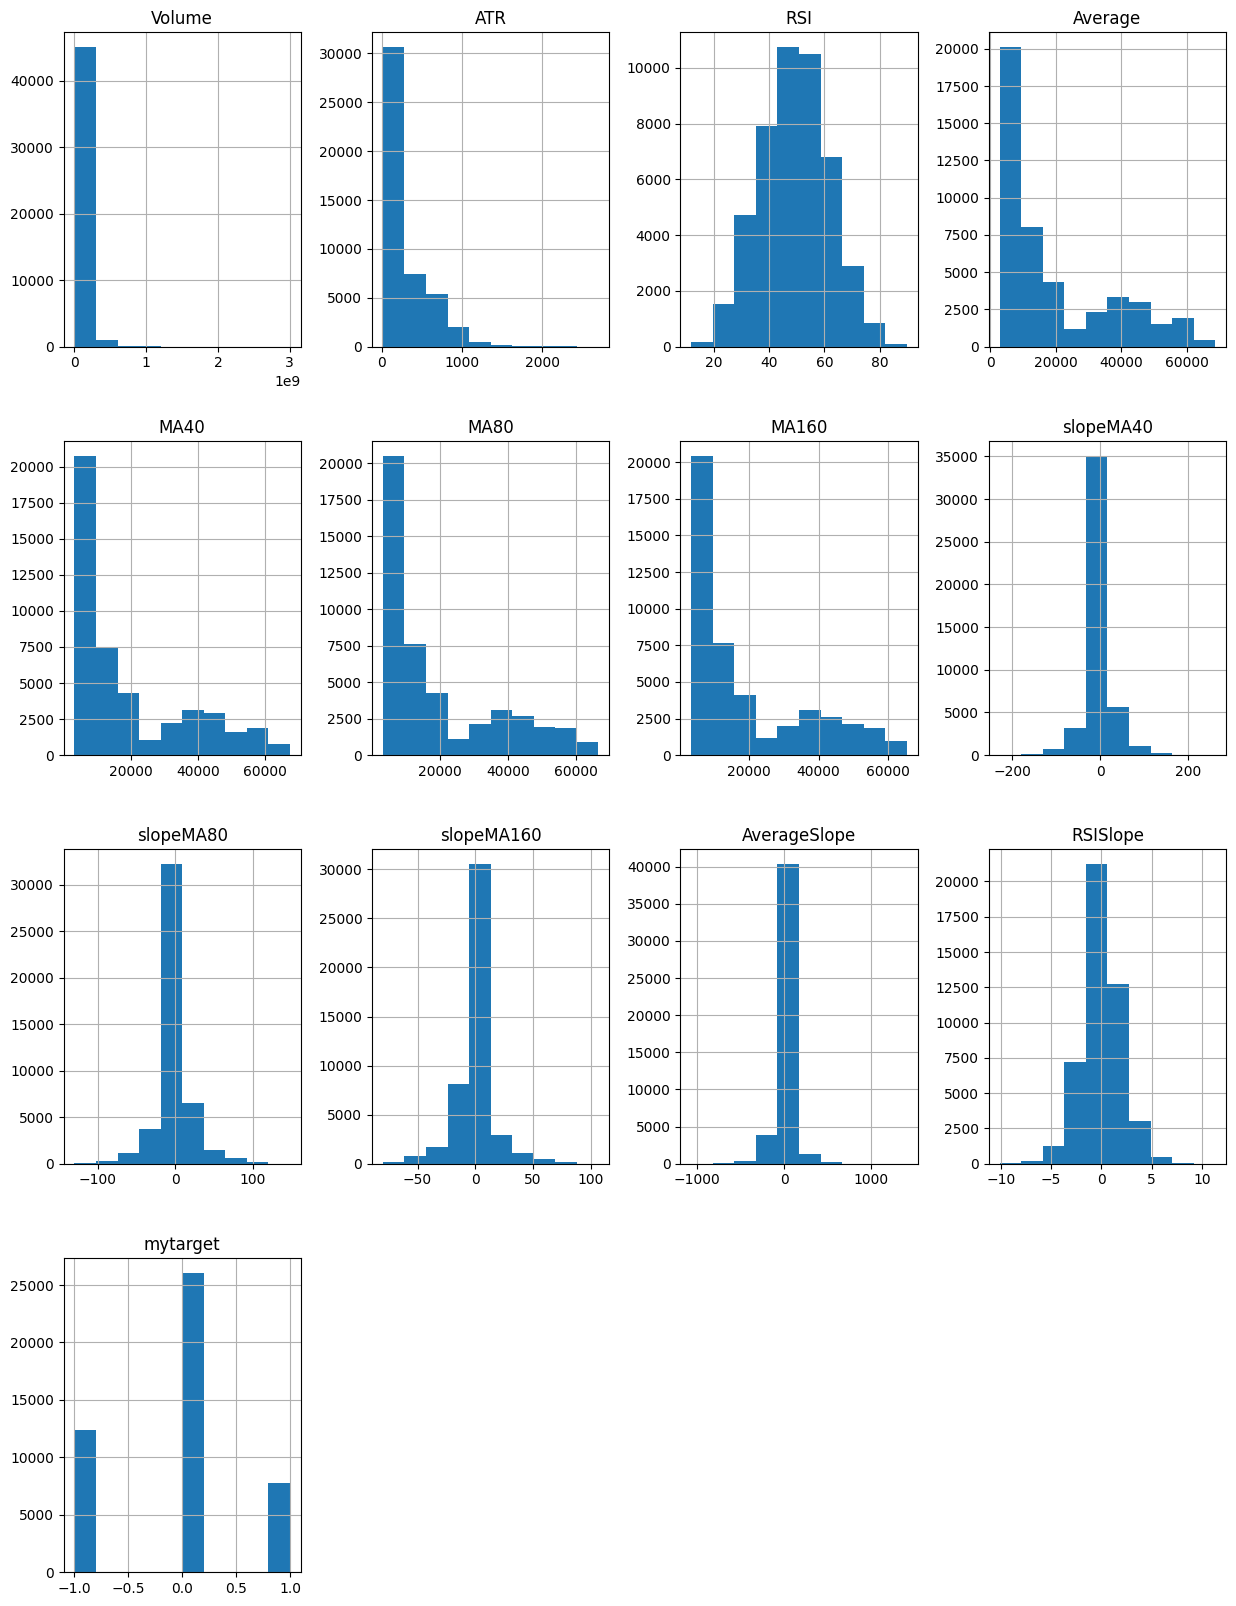

In [66]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

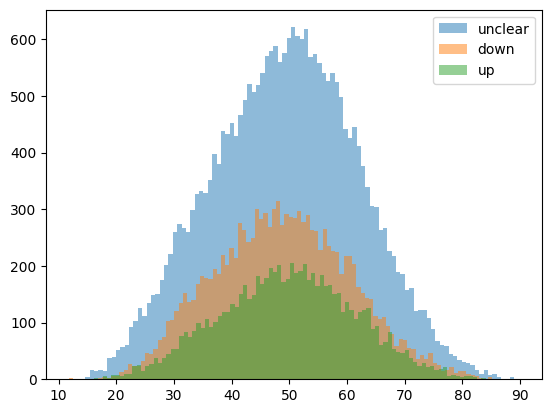

In [67]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 1 ]
df_down=df.RSI[ df['mytarget'] == -1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

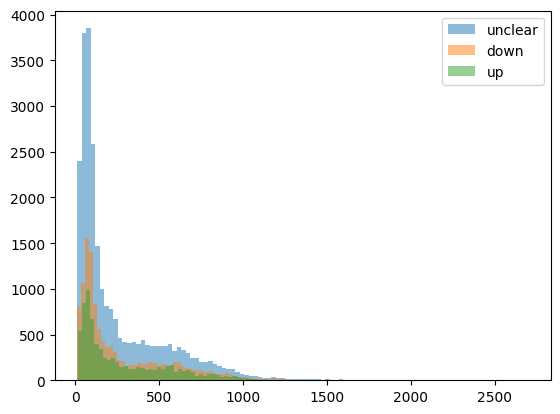

In [68]:
from matplotlib import pyplot
df_up=df.ATR[ df['mytarget'] == 1 ]
df_down=df.ATR[ df['mytarget'] == -1 ]
df_unclear=df.ATR[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

# Machine learning for trend prediction

In [69]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]
X

,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
164,114.991716,39.448390,16475.100,16681.22500,16666.942875,16428.132875,-2.359414,0.077907,0.140318,-10.997714,0.117645
165,114.583130,41.742609,16557.910,16677.97025,16666.952875,16428.463250,-2.572679,0.039746,0.119707,-15.360286,-0.919689
166,117.793974,46.761073,16639.090,16677.72000,16666.340125,16428.773312,-2.410050,-0.129389,0.117321,4.453143,-0.456972
167,120.317275,56.059341,16714.030,16680.15050,16667.137875,16430.665062,-1.581443,-0.090221,0.344287,28.900571,1.921149
168,119.151411,56.639191,16702.500,16681.34575,16668.224625,16432.966687,-0.564357,0.147457,0.815136,43.449857,3.235585
...,...,...,...,...,...,...,...,...,...,...,...
46153,91.359433,54.953229,4266.320,4150.25950,4127.590750,4083.400000,5.111543,3.568207,0.412843,-4.892571,-0.865583
46154,94.387462,52.030026,4210.570,4155.66500,4129.710625,4083.746313,5.264357,3.150393,0.468716,-12.516143,-1.341641
46155,95.261089,56.489609,4284.690,4162.82825,4132.838500,4084.193375,5.417121,2.791829,0.411232,-6.192857,-1.189449
46156,93.326034,56.299274,4309.100,4170.65400,4135.856625,4084.587625,5.953657,2.684900,0.382259,6.077714,-0.417603


In [74]:
y

164      1.0
165     -1.0
166     -1.0
167      0.0
168      0.0
        ... 
46153   -1.0
46154    0.0
46155    0.0
46156    0.0
46157   -1.0
Name: mytarget, Length: 45994, dtype: float64

In [79]:
from backtesting import Backtest, Strategy

def indicator(df: pd.DataFrame):
    return df['mytarget']

class MyTarget(Strategy):
    def init(self):
        self.signal = self.I(indicator, self.data)

    def next(self):
        pass
        # if self.data.mytarget == 1:
        #     self.buy()
        # elif self.data.mytarget == -1:
        #     self.sell()
bt = Backtest(df, MyTarget, cash=20000, commission=0)
stats = bt.run()
stats

/var/folders/9j/zg2w0vvd4kd1c9dmf275gb2h0000gn/T/ipykernel_71176/3032155441.py:16: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(df, MyTarget, cash=20000, commission=0)
/var/folders/9j/zg2w0vvd4kd1c9dmf275gb2h0000gn/T/ipykernel_71176/3032155441.py:16: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyTarget, cash=20000, commission=0)


Start                                     0.0
End                                   46175.0
Duration                              46175.0
Exposure Time [%]                         0.0
Equity Final [$]                      20000.0
Equity Peak [$]                       20000.0
Return [%]                                0.0
Buy & Hold Return [%]              -73.982428
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                  0.0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [80]:
bt.plot()

Row(id='1220', ...)

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [71]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [72]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, -1], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 56.33%
Accuracy test: 56.21%
 0.0    56.376919
-1.0    26.820890
 1.0    16.802192
Name: mytarget, dtype: float64
Accuracy Gambler: 33.75%


## More powerful model XGBoost

In [73]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1.  0.  1.]